<center><a href="https://www.nvidia.cn/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

# 2. 美国手语数据集的图像分类

在本节中，您将使用不同的数据集 [American Sign Language](http://www.asl.gs/) 中手语字母的图像，执行在上一节中观察到的数据准备、模型创建和模型训练的步骤。

## 2.1 目标

在完成本节时，您将能够：
* 准备图像数据进行训练
* 创建并编译用于图像分类的简单模型
* 训练图像分类模型并观察结果

In [1]:
import torch.nn as nn
import pandas as pd
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

## 2.2 手语数据集
我们将使用[美国手语字母表](https://www.kaggle.com/datamunge/sign-language-mnist)图像，该字母表包含 26 个字母。其中有两个字母（j 和 z）涉及一些动作，因此已从本次训练数据集中排除。

<img src="./images/asl.png" style="width: 600px;">

### 2.2.1 Kaggle
[Kaggle](http://www.kaggle.com) 网站提供了此数据集，此网站内容丰富，您还可在其中查找多个数据集和其他深度学习资源。除了数据集之外，内容贡献者还发布了类似于这些 notebook 的“内核”，并向您展示了如何训练模型和探索数据。如果您正在寻找新的深度学习项目以做入门之用，推荐您访问 Kaggle 网站。该网站还会在其组织的竞赛中附加一些数据集，您可以参与其中，在训练高精度模型方面与他人一较高下。

## 2.3 加载数据集

这个数据集无法像 MNIST 一样通过 TorchVision 加载，所以我们先学一下如何加载自定义数据。在本小节的最后，您将获得您所熟悉的`x_train`，`y_train`，`x_valid`和`y_valid`变量。

### 2.3.1 读入数据
手语数据集采用 [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) (Comma Separated Values) 格式，就是 Microsoft Excel 和 Google Sheet 采用的格式。它就是一个由行和列组成的网格，且顶部带有标签。您可以从 [train](data/asl_data/sign_mnist_train.csv) 和 [valid](data/asl_data/sign_mnist_valid.csv) 中看到。

为加载和处理数据，我们将使用一个名为 [Pandas](https://pandas.pydata.org/) 的库，这是一款可供加载和处理数据的高性能工具。我们将 CSV 文件读入名为 [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) 的格式，这是 Pandas 存储数据网格所采用的格式。

Pandas有一个 `read_csv` 方法，该方法将读取 csv 文件，并返回一个数据帧（Dataframe）：

In [2]:
train_df = pd.read_csv("data/asl_data/sign_mnist_train.csv")
valid_df = pd.read_csv("data/asl_data/sign_mnist_valid.csv")

### 2.3.2 探索数据

再来观察一下我们的数据。我们可以使用 [head](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) 函数来抓取数据集的前几行。如您所见，每一行都是一个具有 `label` 列的图像，还有 784 个值代表该图像中的每个像素值，就像 MNIST 数据集一样。请注意，当前标签是数值，而不是字母：

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### 2.3.3 提取标签

与 MNIST 一样，我们希望将训练和测试标签存储在 `y_train` 和 `y_valid` 变量中。可以用 [pop](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pop.html) 方法从 DataFrame 里删除一列并同时赋给一个变量。

In [4]:
y_train = train_df.pop('label')
y_valid = valid_df.pop('label')
y_train

0         3
1         6
2         2
3         2
4        12
         ..
27450    12
27451    22
27452    17
27453    16
27454    22
Name: label, Length: 27455, dtype: int64

### 2.3.4 提取图像

与 MNIST 一样，我们希望将训练和测试图像存储在 `x_train` 和 `x_valid` 变量中。 我们现在创建这些变量：

In [5]:
x_train = train_df.values
x_valid = valid_df.values

### 2.3.5 总结训练和测试数据

我们现在有 27,455 张 784 像素的图像用于训练...

In [6]:
x_train.shape

(27455, 784)

...及其相应的标签：

In [7]:
y_train.shape

(27455,)

我们有 7,172 张图片用于验证...

In [8]:
x_valid.shape

(7172, 784)

...及其相应的标签：

In [9]:
y_valid.shape

(7172,)

## 2.4 数据可视化

我们将再次使用 matplotlib 库来做可视化。您无需担心此可视化的细节，但是如果您愿意，可以稍后再了解有关 [matplotlib](https://matplotlib.org/) 的更多信息。

请注意，我们必须将数据从其当前的 784 像素的 1D 形状重构为 28x28 像素的 2D 形状才能合理呈现图像：

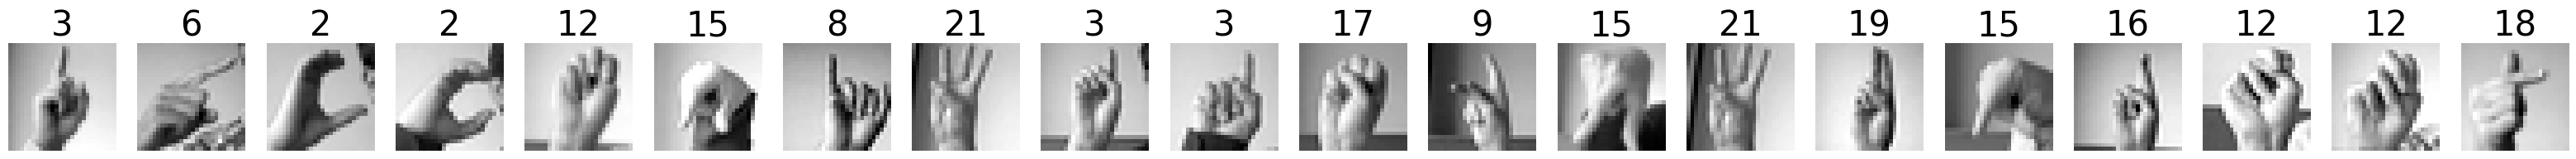

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))

num_images = 20
for i in range(num_images):
    row = x_train[i]
    label = y_train[i]

    image = row.reshape(28,28)
    plt.subplot(1, num_images, i+1)
    plt.title(label, fontdict={'fontsize': 30})
    plt.axis('off')
    plt.imshow(image, cmap='gray')

### 2.4.1 对图像数据进行归一化

#### 练习

正如我们对 MNIST 数据集所做的那样，我们将对图像数据进行归一化，这意味着它们的像素值将不是介于 0 到 255 之间：

In [11]:
x_train.min()

0

In [12]:
x_train.max()

255

在之前的实验中，我们用的是 [ToTensor](https://pytorch.org/vision/main/generated/torchvision.transforms.ToTensor.html)，但还可以在转成 tensor 之前编辑数据。

In [13]:
x_train = train_df.values / 255
x_valid = valid_df.values / 255

### 2.4.2 定制数据集

我们可以使用 PyTorch 的 [Dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) 工具来创建我们自己的数据集。`__init__` 方法会在类初始化时运行一次。`__getitem__` 方法返回我们的图像和标签。

由于我们的数据集足够小，我们可以将其存储在 GPU 上以加快处理速度。在之前的实验中，我们是在从每个批次中抽取数据时将其发送到 GPU。这里，我们将在 `__init__` 函数中就将数据发送到 GPU。

In [14]:
class MyDataset(Dataset):
    def __init__(self, x_df, y_df):
        self.xs = torch.tensor(x_df).float().to(device)
        self.ys = torch.tensor(y_df).to(device)

    def __getitem__(self, idx):
        x = self.xs[idx]
        y = self.ys[idx]
        return x, y

    def __len__(self):
        return len(self.xs)

自定义的 PyTorch 数据集的工作原理与预构建的数据集相同。它应该传递给 [DataLoader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#preparing-your-data-for-training-with-dataloaders) 以用于模型训练。

In [15]:
BATCH_SIZE = 32

train_data = MyDataset(x_train, y_train)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader.dataset)

In [16]:
valid_data = MyDataset(x_valid, y_valid)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)
valid_N = len(valid_loader.dataset)

我们可以用下面的代码验证 DataLoader 是否按预期工作。我们会让 DataLoader 变为[可迭代](https://docs.python.org/3/library/functions.html#iter)的，然后调用 [next](https://docs.python.org/3/library/functions.html#next) 从数据中抽取第一批。

In [17]:
train_loader

尝试多次运行下面的代码，每次的值应该有所不同。

In [18]:
batch = next(iter(train_loader))
batch

[tensor([[0.3020, 0.3098, 0.3255,  ..., 0.8078, 0.8039, 0.8000],
         [0.8353, 0.8392, 0.8431,  ..., 0.2980, 0.3176, 0.2824],
         [0.5059, 0.5176, 0.5294,  ..., 0.4039, 0.5373, 0.7098],
         ...,
         [0.5137, 0.5216, 0.5294,  ..., 0.6588, 0.6549, 0.6549],
         [0.5490, 0.5608, 0.5686,  ..., 0.6510, 0.6471, 0.6431],
         [0.4235, 0.4627, 0.4941,  ..., 0.4000, 0.3961, 0.6431]],
        device='cuda:0'),
 tensor([ 9,  6,  5,  1, 10,  8,  3, 14,  9,  0, 19,  2,  4, 18,  8, 10,  8, 10,
         11,  8, 22, 23,  0,  1, 10,  0,  2, 10,  7,  7, 12,  7],
        device='cuda:0')]

注意,每个批次有两个值。第一个是我们的 `x`，第二个是我们的 `y`。它们的第一个维度应该都有 `32` 个值，即 `batch_size`。

In [19]:
batch[0].shape

torch.Size([32, 784])

In [20]:
batch[1].shape

torch.Size([32])

## 2.5 构建模型

我们已经创建了 DataLoaders，现在是时候构建模型了。

#### 练习

在这个练习中，我们将构建一个 sequential 模型。和之前一样，构建这样一个模型：

* 有一个展平层。
* 有一个密集的输入层。该层应包含 512 个神经元并使用 `relu` 激活函数。
* 有第二个包含 512 个神经元的密集层，使用 `relu` 激活函数。
* 有一个输出层，神经元数等于类别数。

我们先定义一些变量：

In [21]:
input_size = 28 * 28
n_classes = 24

在下面的单元格中完成你的工作，创建一个用于存储模型的 `model` 变量。我们已经导入了 PyTorch 的 [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) 模型类和 [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) 层类供你使用。如果需要提示，可以查看下面的解决方案：

In [22]:
model = nn.Sequential(

)

#### 解答

In [23]:
# SOLUTION
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, 512),  # Input
    nn.ReLU(),  # Activation for input
    nn.Linear(512, 512),  # Hidden
    nn.ReLU(),  # Activation for hidden
    nn.Linear(512, n_classes)  # Output
)

这次,我们将在一步内完成编译模型和将其发送到GPU:

In [24]:
model = torch.compile(model.to(device))
model

OptimizedModule(
  (_orig_mod): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=24, bias=True)
  )
)

由于对这些 ASL 图像进行分类与对 MNIST 手写数字进行分类相似，我们将使用相同的`损失函数`（[Categorical CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)）和`优化器`（[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)）。

In [25]:
loss_function = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())

## 2.6 训练模型

这次，让我们更仔细地看看 `train` 和 `validate` 函数。

### 2.6.1 训练函数

此代码与上一个笔记本中的几乎相同，但我们不再将 `x` 和 `y` 发送到 GPU，因为我们的 DataLoader 已经处理了这件事。

在循环遍历 DataLoader 之前，我们将设置模型为 [model.train](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.train) 模式以确保其参数可以被更新。为了更容易跟踪训练进度，我们将跟踪总的`损失`和`准确率`。

然后，对于 `train_loader` 中的每个批次，我们将：
1. 从模型中获取一个`输出`预测
2. 使用优化器的 [zero_grad](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) 函数将梯度置零
3. 使用我们的`损失函数`计算损失
4. 使用 [backward](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) 计算梯度
5. 使用`优化器`的 [step](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) 函数更新我们的模型参数
6. 更新总的`损失`和`准确率`

In [26]:
def train():
    loss = 0
    accuracy = 0

    model.train()
    for x, y in train_loader:
        output = model(x)
        optimizer.zero_grad()
        batch_loss = loss_function(output, y)
        batch_loss.backward()
        optimizer.step()

        loss += batch_loss.item()
        accuracy += get_batch_accuracy(output, y, train_N)
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### 2.6.2 验证函数

模型在验证期间不学习，因此 `validate` 函数比上面的 `train` 函数稍简单一些。

一个关键的不同是我们将通过 [model.evaluate](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.eval) 将模型设置为评估模式，这将阻止模型更新任何参数。

In [27]:
def validate():
    loss = 0
    accuracy = 0

    model.eval()
    with torch.no_grad():
        for x, y in valid_loader:
            output = model(x)

            loss += loss_function(output, y).item()
            accuracy += get_batch_accuracy(output, y, valid_N)
    print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy))

### 2.6.3 计算准确率

`train` 和 `validate` 函数都使用 `get_batch_accuracy`，但我们尚未在这个 notebook 中定义它。

#### 练习

下面的函数有三个 `FIXME`。每个对应于函数的输入参数。你能用正确的参数替换每个 FIXME 吗?

查看 [argmax](https://pytorch.org/docs/stable/generated/torch.argmax.html)，[eq](https://pytorch.org/docs/stable/generated/torch.eq.html) 和 [view_as](https://pytorch.org/docs/stable/generated/torch.Tensor.view_as.html) 文档可能会有所帮助。

#### 解答

点击 `...` 查看答案。

In [28]:
# SOLUTION
def get_batch_accuracy(output, y, N):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / N

### 2.6.3 训练循环

让我们把所有内容结合起来！运行下面的单元格训练 20 个 epochs。

In [29]:
epochs = 20

for epoch in range(epochs):
    print('Epoch: {}'.format(epoch))
    train()
    validate()

Epoch: 0
Train - Loss: 1582.9830 Accuracy: 0.3914
Valid - Loss: 307.4245 Accuracy: 0.5502
Epoch: 1
Train - Loss: 711.0378 Accuracy: 0.7220
Valid - Loss: 249.7293 Accuracy: 0.6373
Epoch: 2
Train - Loss: 383.3563 Accuracy: 0.8543
Valid - Loss: 211.3164 Accuracy: 0.7137
Epoch: 3
Train - Loss: 218.4240 Accuracy: 0.9179
Valid - Loss: 230.8348 Accuracy: 0.7381
Epoch: 4
Train - Loss: 135.3097 Accuracy: 0.9521
Valid - Loss: 212.1813 Accuracy: 0.7529
Epoch: 5
Train - Loss: 82.2021 Accuracy: 0.9728
Valid - Loss: 241.8563 Accuracy: 0.7557
Epoch: 6
Train - Loss: 73.6606 Accuracy: 0.9746
Valid - Loss: 278.6982 Accuracy: 0.6994
Epoch: 7
Train - Loss: 45.5769 Accuracy: 0.9860
Valid - Loss: 331.5339 Accuracy: 0.7193
Epoch: 8
Train - Loss: 94.6634 Accuracy: 0.9668
Valid - Loss: 286.8705 Accuracy: 0.7276
Epoch: 9
Train - Loss: 9.4087 Accuracy: 0.9988
Valid - Loss: 246.0969 Accuracy: 0.7943
Epoch: 10
Train - Loss: 67.1537 Accuracy: 0.9773
Valid - Loss: 223.0578 Accuracy: 0.8081
Epoch: 11
Train - Loss: 33

### 2.6.4 讨论：发生了什么？
我们可以看到训练集上的准确率已经相当高，但验证准确率却没有那么高。您认为此处发生了什么？先思考片刻再查看下一部分的内容。

#### 解答

这是一个典型的例子，即模型学习了对训练集里的数据进行分类，但对于尚未采用的新数据进行分类的表现却并不理想。从本质上讲，这是由于模型只是在训练中记忆数据，而非真正获得对该问题（数据分类）的理解。这是一个常见的问题，称为*过拟合（overfitting）*。在接下来的两个讲座中，我们将讨论过拟合以及解决此问题的一些方法。

## 2.7 总结

在本节中，您构建了自己的神经网络来执行图像分类，取得了很不错的准确率。恭喜！

到这里为止，您应该对加载数据（包括标签）、准备数据、创建模型以及使用准备好的数据训练模型的过程有所了解了。

### 2.7.1 清理显存
在进入下一节内容前，请先执行以下单元，以清理 GPU 显存。转至下一 notebook 之前需要执行此操作。

In [30]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### 2.7.2 下一步

现在，您已经建立了几个虽然基本但还是有效的模型，您将开始学习更复杂的模型，包括*卷积神经网络*。